<a href="https://colab.research.google.com/github/berryperi/project/blob/main/coco%EC%98%88%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/zips/train2017.zip

!unzip -q annotations_trainval2017.zip -d /content/
!unzip -q train2017.zip -d /content/
!unzip -q val2017.zip -d /content/

!rm annotations_trainval2017.zip
!rm train2017.zip
!rm val2017.zip

--2024-03-17 04:47:22--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.182.74.97, 52.217.116.57, 52.217.229.121, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.182.74.97|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  94.4MB/s    in 2.6s    

2024-03-17 04:47:25 (94.4 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

--2024-03-17 04:47:25--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.28.246, 54.231.137.97, 16.182.74.25, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.28.246|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.

In [ ]:
import cv2
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import json
from PIL import Image, ImageDraw
import os
import pandas as pd
import torch

In [ ]:
# device 설정 (CUDA 사용 가능한 경우)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
# 데이터셋 경로
train2017='/content/train2017/'
train_annotation2017='/content/annotations/instances_train2017.json'
val2017='/content/val2017/'
val_annotation2017='/content/annotations/instances_val2017.json'

In [ ]:
# JSON 파일을 불러옴
with open(train_annotation2017) as t:
    t_data = json.load(t)

print(t_data.keys())

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])


In [ ]:
# 데이터를 각각 추출
t_annotations = t_data['annotations']
t_train_images = t_data['images']
t_categories = t_data['categories']

# pandas 데이터프레임으로 변환
t_annotations_df = pd.DataFrame(t_annotations)
t_images_df = pd.DataFrame(t_train_images)
t_categories_df = pd.DataFrame(t_categories)

In [ ]:
# JSON 파일을 불러옴
with open(val_annotation2017) as v:
    v_data = json.load(v)

# 데이터를 각각 추출
v_annotations = v_data['annotations']
v_train_images = v_data['images']
v_categories = v_data['categories']

# pandas 데이터프레임으로 변환
v_annotations_df = pd.DataFrame(v_annotations)
v_images_df = pd.DataFrame(v_train_images)
v_categories_df = pd.DataFrame(v_categories)

In [ ]:
t_annotations_df.info()

In [ ]:
v_annotations_df.info()

In [ ]:
t_images_df.info()

In [ ]:
v_images_df.info()

In [ ]:
t_categories_df.info()

In [ ]:
v_categories_df.info()

In [ ]:
#  두 데이터프레임을 'id'와 'image_id' 열을 기준으로 내부 머지
train_df = pd.merge(t_images_df, t_annotations_df, how="inner", left_on='id', right_on='image_id')

# 기존 데이터프레임과 카테고리 데이터프레임을 내부 머지
train_df = pd.merge(train_df, t_categories_df, how="inner", left_on='category_id', right_on='id')

# 불필요한 열을 제거
train_df.drop(["id_x", "id"], axis=1, inplace=True)

# 열 이름을 직관적으로 변경
train_df.rename(columns={
    "id_y": "object_id",
    "name": "category_name"
}, inplace=True)

In [ ]:
#  두 데이터프레임을 'id'와 'image_id' 열을 기준으로 내부 머지
val_df = pd.merge(v_images_df, v_annotations_df, how="inner", left_on='id', right_on='image_id')

# 기존 데이터프레임과 카테고리 데이터프레임을 내부 머지
val_df = pd.merge(val_df, v_categories_df, how="inner", left_on='category_id', right_on='id')

# 불필요한 열을 제거
val_df.drop(["id_x", "id"], axis=1, inplace=True)

# 열 이름을 직관적으로 변경
val_df.rename(columns={
    "id_y": "object_id",
    "name": "category_name"
}, inplace=True)

In [ ]:
train_df.info()

In [ ]:
val_df.info()

,license,file_name,coco_url,height,width,date_captured,flickr_url,segmentation,area,iscrowd,image_id,bbox,category_id,object_id,supercategory,category_name
0,4,000000397133.jpg,http://images.cocodataset.org/val2017/00000039...,427,640,2013-11-14 17:02:52,http://farm7.staticflickr.com/6116/6255196340_...,"[[224.24, 297.18, 228.29, 297.18, 234.91, 298....",1481.38065,0,397133,"[217.62, 240.54, 38.99, 57.75]",44,82445,kitchen,bottle
1,3,000000355257.jpg,http://images.cocodataset.org/val2017/00000035...,427,640,2013-11-20 23:51:16,http://farm3.staticflickr.com/2869/8759177830_...,"[[267.63, 91.78, 257.63, 88.59, 257.63, 80.59,...",1864.97305,0,355257,"[250.44, 11.04, 26.78, 81.94]",44,92491,kitchen,bottle


In [ ]:
# train_df에서 랜덤하게 하나의 row를 선택
random_row = train_df.sample(n=1).iloc[0]

# 이미지 파일 경로를 구성
img_path = os.path.join(train2017, random_row['file_name'])

# 이미지를 불러옴
image = cv2.imread(img_path)

# OpenCV는 이미지를 BGR 형식으로 불러오므로, plt로 표시하기 전에 RGB 형식으로 변환
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 이미지를 표시
plt.imshow(image_rgb)
plt.axis('off')  # 축 정보 제거
plt.show()

In [ ]:
# train_df에서 이미지와 같은 image_id를 가진 모든 어노테이션을 선택
image_annotations = train_df[train_df['image_id'] == random_row['image_id']]

# 이미지에 어노테이션을 시각화
for _, ann in image_annotations.iterrows():
    # 바운딩 박스 그리기
    bbox = np.array(ann['bbox']).astype(int)
    cv2.rectangle(image_rgb, ((bbox[0]), (bbox[1])),
                  ((bbox[0] + bbox[2]), (bbox[1] + bbox[3])), (255, 0, 0), 1)

    # 카테고리 이름 표시
    cat_name = ann['category_name']
    cv2.putText(image_rgb, cat_name, ((bbox[0]), (bbox[1] - 10)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Segmentation 그리기
    if type(ann['segmentation']) == list:
        for segmentation in ann['segmentation']:
            poly = np.array(segmentation).reshape((-1, 1, 2))
            cv2.polylines(image_rgb, [poly.astype(np.int32)], True, (0, 255, 0), 2)

# 변경된 이미지를 시각화
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [ ]:
# 'person' 카테고리에 해당하는 category_id 찾기
person_category_id = t_categories_df[t_categories_df['name'] == 'person']['id'].iloc[0]

# 랜덤하게 4장의 이미지를 선택
sample_images = train_df.sample(n=4)

# 2x2 서브플롯 생성
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.ravel()

for i, (_, row) in enumerate(sample_images.iterrows()):
    # 이미지 파일 경로
    img_path = os.path.join(train2017, row['file_name'])
    # 이미지를 불러옴
    image = cv2.imread(img_path)
    # OpenCV는 이미지를 BGR 형식으로 불러오므로, plt로 표시하기 전에 RGB 형식으로 변환
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # 현재 이미지에 대한 어노테이션을 선택
    image_annotations = train_df[(train_df['image_id'] == row['image_id']) & (train_df['category_id'] == person_category_id)]

    # 이미지에 어노테이션을 시각화
    for _, ann in image_annotations.iterrows():
        # 바운딩 박스 그리기
        bbox = np.array(ann['bbox']).astype(int)
        cv2.rectangle(image_rgb, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]),
                      (255, 0, 0), 1)

        # 카테고리 이름 표시
        cat_name = ann['category_name']
        cv2.putText(image_rgb, cat_name, (bbox[0], bbox[1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Segmentation 그리기
        if type(ann['segmentation']) == list:
            for segmentation in ann['segmentation']:
                poly = np.array(segmentation).reshape((-1, 1, 2))
                cv2.polylines(image_rgb, [poly.astype(np.int32)], True, (0, 255, 0), 2)

    # 서브플롯에 이미지를 표시
    axs[i].imshow(image_rgb)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from torchvision.transforms import transforms

# 변환 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),  # 이미지를 Tensor로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 정규화
])

In [ ]:
from torchvision.transforms.functional import to_pil_image
import torch

# PIL 이미지로 변환
image_pil = Image.fromarray(image_rgb)

# 정의된 변환 적용
transformed_image = transform(image_pil)

# Tensor 이미지를 시각화하기 위해 (C, H, W)에서 (H, W, C)로 변경하고, [0, 1] 범위로 정규화
transformed_image_np = transformed_image.numpy().transpose((1, 2, 0))
transformed_image_np = np.clip(transformed_image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)

# 시각화
plt.figure(figsize=(6, 6))
plt.imshow(transformed_image_np)
plt.axis('off')
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder 인스턴스 생성
label_encoder = LabelEncoder()

train_df['category_name_encoded'] = label_encoder.fit_transform(train_df['category_name'])
val_df['category_name_encoded'] = label_encoder.fit_transform(val_df['category_name'])

train_df['supercategory_encoded'] = label_encoder.fit_transform(train_df['supercategory'])
val_df['supercategory_encoded'] = label_encoder.fit_transform(val_df['supercategory'])

In [ ]:
t_person_encoded = train_df[train_df['category_name'] == 'person']['category_name_encoded'].values[0]
print("t_Person 인코딩된 값:", t_person_encoded)

v_person_encoded = val_df[val_df['category_name'] == 'person']['category_name_encoded'].values[0]
print("v_Person 인코딩된 값:", v_person_encoded)

t_Person 인코딩된 값: 49
v_Person 인코딩된 값: 49


In [ ]:
train_df.drop(columns=['category_name', 'supercategory', 'coco_url', 'date_captured', 'flickr_url'], inplace=True)
val_df.drop(columns=['category_name', 'supercategory', 'coco_url', 'date_captured', 'flickr_url'], inplace=True)

In [ ]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36781 entries, 0 to 36780
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   license                36781 non-null  int64  
 1   file_name              36781 non-null  object 
 2   height                 36781 non-null  int64  
 3   width                  36781 non-null  int64  
 4   segmentation           36781 non-null  object 
 5   area                   36781 non-null  float64
 6   iscrowd                36781 non-null  int64  
 7   image_id               36781 non-null  int64  
 8   bbox                   36781 non-null  object 
 9   category_id            36781 non-null  int64  
 10  object_id              36781 non-null  int64  
 11  category_name_encoded  36781 non-null  int64  
 12  supercategory_encoded  36781 non-null  int64  
dtypes: float64(1), int64(9), object(3)
memory usage: 4.9+ MB


In [ ]:
from torch.utils.data import Dataset
from pycocotools import mask as maskUtils

class CustomCocoDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):

        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_info = self.dataframe.iloc[idx]
        path = os.path.join(self.image_dir, img_info['file_name'])
        image = Image.open(path).convert("RGB")
        img_width, img_height = image.size

        annotations = self.dataframe[self.dataframe['image_id'] == img_info['image_id']]
        annotations = annotations[annotations['category_name_encoded'] == 49]

        boxes = []
        masks = []
        for _, ann in annotations.iterrows():
            # 바운딩 박스 처리
            bbox = ann['bbox']
            x_min, y_min, width, height = bbox
            x_max = x_min + width
            y_max = y_min + height
            boxes.append([x_min, y_min, x_max, y_max])

            # 세그멘테이션 처리
            segmentation_info = ann['segmentation']
            binary_mask = np.zeros((img_height, img_width), dtype=np.uint8)
            if isinstance(segmentation_info, dict):
                binary_mask = maskUtils.decode(segmentation_info).squeeze()

            elif isinstance(segmentation_info, list):
                for polygon in segmentation_info:

                    if isinstance(polygon, list):  # 다각형 좌표 리스트
                        rle = maskUtils.frPyObjects([polygon], img_height, img_width)[0] # rle 객체 리스트중 첫번째
                        binary_mask |= maskUtils.decode(rle).squeeze()

                    elif isinstance(polygon, dict):  # RLE 형식의 딕셔너리
                        binary_mask |= maskUtils.decode(polygon).squeeze()

            masks.append(binary_mask)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        masks = np.array(masks, dtype=np.uint8)  # 리스트를 numpy 배열로 변환
        masks = torch.as_tensor(masks, dtype=torch.uint8)  # numpy 배열을 tensor로 변환
        labels = torch.ones((len(boxes),), dtype=torch.int64)
        image_id = torch.tensor([img_info['image_id']])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': image_id,
            'iscrowd': iscrowd
        }

        if self.transforms is not None:
            image = self.transforms(image)

        return image, target


In [ ]:
from torchvision.transforms import transforms

# 이미지 변환 정의
train_transforms = transforms.Compose([
    transforms.Resize((800, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [ ]:
# train_df와 val_df에서 사용자 정의 데이터셋 생성
train_dataset = CustomCocoDataset(dataframe=train_df, image_dir='/content/train2017/',
                                  transforms=train_transforms)
val_dataset = CustomCocoDataset(dataframe=val_df, image_dir='/content/val2017/',
                                transforms=val_transforms)

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    images = [item[0] for item in batch]  # 이미지 데이터
    targets = [item[1] for item in batch]  # 타겟 데이터

    # 이미지들을 torch.stack을 사용하여 하나의 배치로 합침
    images = torch.stack(images, dim=0)

    return images, targets

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)

In [ ]:
images, targets = next(iter(train_loader))
print(images.shape)
# targets는 딕셔너리 리스트이므로, 각 타겟의 형태를 직접 확인.

torch.Size([4, 3, 256, 256])


In [ ]:
# `targets` 리스트의 각 요소에 대해 반복하여 정보를 출력합니다.
for i, target in enumerate(targets):
    # i는 이미지 인덱스, target은 해당 이미지에 대한 정보(딕셔너리)입니다.
    print(f"Image {i} - boxes: {target['boxes']}")
    print(f"Image {i} - labels: {target['labels']}")
    print(f"Image {i} - iscrowd: {target['iscrowd']}")
    print(f"Image {i} - masks: {target['masks']}")
    print(f"Image {i} - image_id: {target['image_id']}")

Image 0 - boxes: tensor([])
Image 0 - labels: tensor([], dtype=torch.int64)
Image 0 - iscrowd: tensor([], dtype=torch.int64)
Image 0 - masks: tensor([], dtype=torch.uint8)
Image 0 - image_id: tensor([47916])
Image 1 - boxes: tensor([[  1.8300,  36.6500, 524.9400, 417.7500]])
Image 1 - labels: tensor([1])
Image 1 - iscrowd: tensor([0])
Image 1 - masks: tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)
Image 1 - image_id: tensor([421393])
Image 2 - boxes: tensor([])
Image 2 - labels: tensor([], dtype=torch.int64)
Image 2 - iscrowd: tensor([], dtype=torch.int64)
Image 2 - masks: tensor([], dtype=torch.uint8)
Image 2 - image_id: tensor([236515])
Image 3 - boxes: tensor([[148.3600,  52.8800, 288.8000, 286.7600],
        [415.2800, 176.8300, 445.6900, 256.0100],
        [396.7700, 177.9800, 420.5700,

In [ ]:
import matplotlib.patches as patches

# 이미지와 타겟 데이터를 시각화
def visualize_image_with_targets(image, target, image_id):
    fig, ax = plt.subplots(1)
    ax.imshow(image.permute(1, 2, 0))  # 이미지의 차원을 (C, H, W)에서 (H, W, C)로 변경

    # 바운딩 박스를 이미지 위에 그립니다.
    for box in target['boxes']:
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # 세그멘테이션 마스크를 이미지 위에 그립니다. (선택적)
    # 마스크가 여러 개 있는 경우
    for mask in target['masks']:
        ax.imshow(mask, cmap='gray', alpha=0.5)  # 마스크를 반투명하게 표시

    plt.title(f"Image ID: {image_id.item()}")
    plt.show()

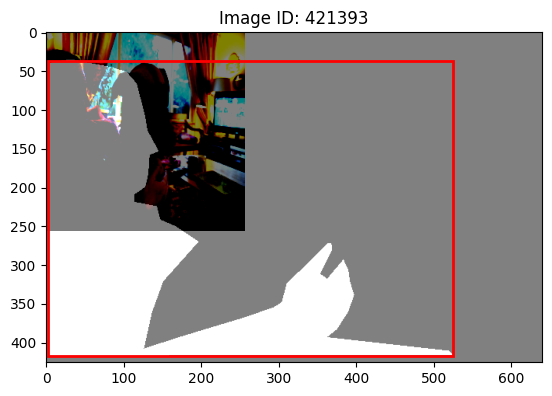

In [ ]:
visualize_image_with_targets(images[1], targets[1], targets[1]['image_id'])